In [8]:
import numpy as np
import pickle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import scripts.map_and_average as mapper
import scripts.util_feature_learning as util_feature_learning

## Load data

In [2]:
trainset, valset, testset = mapper.load_train_val_test_sets()
traindata, trainlabels, trainaudiolabels = trainset
valdata, vallabels, valaudiolabels = valset
testdata, testlabels, testaudiolabels = testset
labels = np.concatenate((trainlabels, vallabels, testlabels)).ravel()
audiolabels = np.concatenate((trainaudiolabels, valaudiolabels, testaudiolabels)).ravel()
print traindata.shape, valdata.shape, testdata.shape

/import/c4dm-04/mariap/train_data_melodia_8.pickle
(325435, 840) (106632, 840) (107083, 840)


## explain LDA

mapping rhy
training with PCA transform...
variance explained 1.0
138 400
training with PCA transform...
variance explained 0.990084387566
training with LDA transform...
variance explained 1.0
mapping mel
training with PCA transform...
variance explained 1.0
214 240
training with PCA transform...
variance explained 0.990298772177
training with LDA transform...
variance explained 1.0
mapping mfc
training with PCA transform...
variance explained 1.0
39 80
training with PCA transform...
variance explained 0.991435457701
training with LDA transform...
variance explained 0.962216871623
mapping chr
training with PCA transform...
variance explained 1.0
69 120
training with PCA transform...
variance explained 0.989994092326
training with LDA transform...
variance explained 0.96455301758


/homes/mp305/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


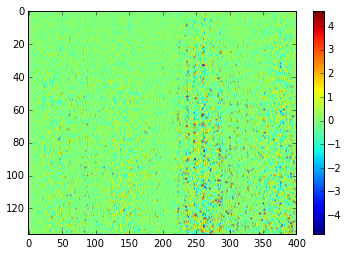

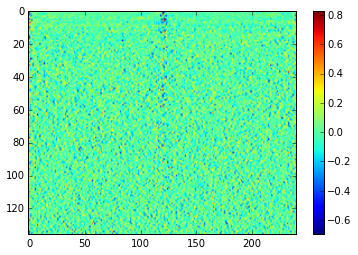

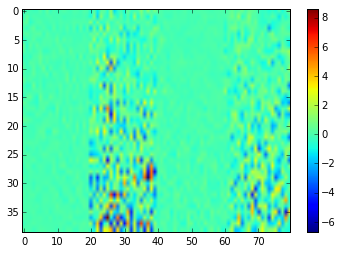

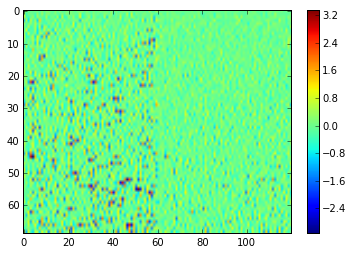

In [6]:
min_variance = 0.99
feat_labels, feat_inds = mapper.get_feat_inds(n_dim=traindata.shape[1])
for i in range(len(feat_inds)):
    print "mapping " + feat_labels[i]
    inds = feat_inds[i]
    ssm_feat = util_feature_learning.Transformer()
    if min_variance is not None:
        ssm_feat.fit_data(traindata[:, inds], trainlabels, n_components=len(inds), pca_only=True)
        n_components = np.where(ssm_feat.pca_transformer.explained_variance_ratio_.cumsum()>min_variance)[0][0]+1
        print n_components, len(inds)
        ssm_feat.fit_lda_data(traindata[:, inds], trainlabels, n_components=n_components)

        WW = ssm_feat.lda_transformer.scalings_
        plt.figure()
        plt.imshow(WW[:, :n_components].T, aspect='auto')
        plt.colorbar()

## explain classifier

In [9]:
X_list, Y, Yaudio = pickle.load(open('../data/lda_data_melodia_8.pickle','rb'))
Xrhy, Xmel, Xmfc, Xchr = X_list
X = np.concatenate((Xrhy, Xmel, Xmfc, Xchr), axis=1)

## split train/test sets for classifier same as train/test sets of LDA transformer

In [12]:
# train, test indices
aa_train = np.unique(trainaudiolabels)
aa_test = np.unique(testaudiolabels)
traininds = np.array([i for i, item in enumerate(Yaudio) if item in aa_train])
testinds = np.array([i for i, item in enumerate(Yaudio) if item in aa_test])
X_train, Y_train = X[traininds, :], Y[traininds]
X_test, Y_test = X[testinds, :], Y[testinds]

In [13]:
print traininds.shape, testinds.shape
print np.unique(Y_train), np.unique(Y_test)

(4916,) (1635,)
['Afghanistan' 'Algeria' 'Angola' 'Antigua and Barbuda' 'Argentina'
 'Armenia' 'Australia' 'Austria' 'Azerbaijan' 'Belgium' 'Belize' 'Benin'
 'Bhutan' 'Bolivia' 'Botswana' 'Brazil' 'Bulgaria' 'Cambodia' 'Cameroon'
 'Canada' 'Chad' 'Chile' 'China' 'Colombia' 'Costa Rica' 'Croatia' 'Cuba'
 'Czech Republic' 'Democratic Republic of the Congo' 'Denmark'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Ethiopia' 'Fiji'
 'Finland' 'France' 'French Guiana' 'French Polynesia' 'Gabon' 'Gambia'
 'Germany' 'Ghana' 'Greece' 'Grenada' 'Guatemala' 'Guinea' 'Guyana' 'Haiti'
 'Honduras' 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq' 'Ireland'
 'Israel' 'Italy' 'Ivory Coast' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan'
 'Kenya' 'Kiribati' 'Kyrgyzstan' 'Laos' 'Latvia' 'Lebanon' 'Lesotho'
 'Liberia' 'Lithuania' 'Macedonia' 'Malawi' 'Mali' 'Malta' 'Mexico'
 'Mongolia' 'Morocco' 'Mozambique' 'Myanmar' 'Nepal' 'Netherlands'
 'New Zealand' 'Nicaragua' 'Nigeria' 'Norway' 'Pakistan' 'Pan

In [14]:
ssm_feat.classify_and_save(X_train, Y_train, X_test, Y_test)

NameError: global name 'modelKNN' is not defined

In [ ]:
def components_plot(lda_transformer, XX, n_comp=42, figurename=None):
    WW=lda_transformer.scalings_
    Xlda=lda_transformer.transform(XX)
    Xww=numpy.dot(XX, WW[:, :n_comp])
    plt.figure()
    plt.imshow(Xlda - Xww, aspect='auto')
    plt.figure()
    plt.imshow(Xlda, aspect='auto')
    plt.figure()
    plt.imshow(Xww, aspect='auto')
    plt.figure()
    plt.imshow(WW[:, :n_comp], aspect='auto') # this explains the weights up to n_components=64
    if figurename is not None:
        plt.savefig(figurename)

XX = traindata[:, inds]
components_plot(ssm_feat.lda_transformer, XX, n_comp=n_components)